In [1]:
%matplotlib inline
import os
import shap
import pickle
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from statsmodels.stats.multitest import fdrcorrection
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  train_test_split
from sklearn.metrics import plot_precision_recall_curve, roc_auc_score,\
    roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', 118)

In [2]:
names_dict = {'dev_lang_dis':'Language delay or language disorder',
              'behav_adhd':'ADHD or ADD',
              'mood_or_anx':'Mood, Depression, Anxiety or OCD',
              'attn_behav':'Attention or behavior disorders',
              'dev_lang':'Speech/ language/ intellectual/ learning disability/cognitive Impairment/ or other developmental delay or disability',
              'mood_anx': 'Anxiety disorder',
              'final_score_scq': 'SCQ score',
              'mood_dep':"Depression or dysthymia",
              'fine_motor_handwriting':'DCDQ - fine motor handwriting',
              'susp_cause_enviro':'Reported suspected cause of ASD - Environmental exposures',
              'Suspected cause of ASD - Environmental exposures':'Reported suspected cause of ASD - Environmental exposures',
              'i_stereotyped_behavior_score': 'RBS-r stereotyped behaviorscore',
              'mood_soc_anx':'Social Anxiety Disorder/Social Phobia',
              'susp_cause_vaccine': 'Reported suspected cause of ASD - vaccine',
              'Suspected cause of ASD - vaccine':'Reported suspected cause of ASD - vaccine',
              'behav_odd':'Oppositional Defiant Disorder',
              'control_during_movement':'DCDQ - control during movement',
              'dev_id':'Intellectual disability, cognitive impairment, global developmental delay, or borderline intellectual functioning',
              'feeding_dx':'Feeding/eating problems',
              'dev_ld':'Learning disability',
              'v_sameness_behavior_score':'RBS-r - sameness',
              'eating_probs':'Problems with eating foods - not diagnosed by a professional',
              'general_coordination':'DCDQ - general coordination',
              'final_score_dcdq': 'DCDQ final score',
              'med_cond_visaud':'Vision or hearing conditions',
              'iii_compulsive_behavior_score':'RBS-r - compulsive behavior score',
              'father_highest_education': "Father's highest education",
              'total_final_score_rebs-r':'RBS-r - final score',
              'mood_ocd':'Obsessive-Compulsive Disorder',
              'ii_self_injurious_score':'RBS-R - self injurious behavior',
              'sleep_probs':'Sleep problems not diagnosed by a professional',
              'dev_motor':'Motor delay',
              'med_cond_birth':'Birth or pregnancy complications',
              'mother_highest_education':"Mother's highest education",
              'iv_ritualistic_behavior_score': 'RBS-r - ritualistic behavior',
              'vi_restricted_behavior_score': "RBS-r - restricted behavior",
              'mood_dmd':'Disruptive Mood Dysregulation Disorder',
              ' Disruptive Mood Dysregulation Disorder':'Disruptive Mood Dysregulation Disorder',
             'susp_cause_preg': 'Reported suspected cause of ASD - Problems during pregnancy',
              'Suspected cause of ASD - Problems during pregnancy': 'Reported suspected cause of ASD - Problems during pregnancy',
             'susp_cause_pg_drug_etoh': 'Reported suspected cause of ASD - Drug or alcohol exposure in pregnancy',
              'Suspected cause of ASD - Drug or alcohol exposure in pregnancy':'Reported suspected cause of ASD - Drug or alcohol exposure in pregnancy',
             'susp_cause_birth': 'Reported suspected cause of ASD - Birth or delivery complication',
              'Suspected cause of ASD - Birth or delivery complication':'Reported suspected cause of ASD - Birth or delivery complication',
             'Suspected cause of ASD - Suspected cause of ASD':'Reported suspected cause of ASD - Birth or delivery complication',
              'Suspected cause of ASD - Birth or delivery complication':'Reported suspected cause of ASD - Birth or delivery complication',
             'nuclear_family_asd': 'Nuclear family ASD',
             'extended_family_asd': 'Extended family ASD',
             'zygosity_dz': 'Dizygotic twin',
             'twin_mult_birth_no': 'No twin',
             'twin_mult_birth_twin': 'Twin',
             'behav_conduct': 'Conduct Disorder',
             'behav_intermitt_explos': 'Intermittent Explosive Disorder',
             'mood_bipol': 'Bipolar Disorder',
             'mood_hoard': 'Hoarding',
             'mood_sep_anx': 'Separation Anxiety',
             'schiz': 'Schizophrenia, Other Psychosis or Schizoaffective Disorder',
             'cognitive_impairment': 'Cognitive impairment',
             'dev_soc_prag': 'Social Communication Disorder',
             'dev_speech': 'Speech articulation problems',
             'sleep_dx': 'Sleep Disorder diagnosed by a professional',
             'tics': 'Tourette Syndrome or Tic Disorder',
             'neuro_sz': 'Seizure disorder or epilepsy',
             'med_cond_neuro': 'Neurological conditions',
             'birth_prem': 'Premature birth (delivery before 37 weeks)',
             'birth_oxygen': 'Insufficient oxygen at birth with NICU stay',
             'cog_med': 'Cognitive delays or impairment due to a medical condition or exposure',
             'neuro_tbi': 'Traumatic brain injury',
             'med_cond_growth': 'Growth conditions',
             'growth_low_wt': 'Difficulty gaining weight',
             'growth_macroceph': 'Macrocephaly',
             'growth_obes': 'Obesity',
             'growth_short': 'Short stature',
             'visaud_strab': 'Strabismus',
             'susp_cause_medical':"Reported suspected cause of ASD - Medical conditions",
             'Suspected cause of ASD - Medical conditions':"Reported suspected cause of ASD - Medical conditions",
             'sex':'Sex',
             'mood_bipol':'Bipolar DisorderDepression or dysthymia',
             'med_cond_birth':'Birth or pregnancy complications',
             "annual_household_income":"Annual household income",
             "YOB":"Year of birth"}

data = pd.read_pickle('culsteres_late.df').rename(columns = names_dict)
data_y = pd.read_pickle('data_y.df').rename(columns = names_dict).drop('gest_age', axis = 1)
data_y['clusters'] = 2
data = pd.concat([data, data_y])

In [3]:
# cat_cols = []
# for i, col in enumerate(data.drop(['clusters'], axis = 1).columns):
#     if len(set(data[col].replace(-1,np.nan).dropna()).symmetric_difference({0,1})) == 0:
#         cat_cols.append(i)

# x_train, x_test, y_train, y_test = train_test_split(data.drop(['clusters'], axis = 1), data.clusters, test_size = 0.25)
# sm = SMOTENC(categorical_features=cat_cols)
# x_train, y_train = sm.fit_resample(x_train, y_train)

In [ ]:
# params = {'n_estimators':list(range(1500,2001,100)), 'criterion':['gini','entropy'],
#           'max_depth':list(range(4,11)), 'max_features':['auto','log2', 4,5,6],
#           'bootstrap': ['True', 'False']}
# scoring = 'f1_micro'
# RF = RandomForestClassifier()
# gs = GridSearchCV(RF, params, scoring = scoring, n_jobs=-1, refit=True ,cv = 10)
# gs.fit(x_train, y_train)
# clf = gs.best_estimator_ 

In [ ]:
# estimators = [gs, clf, x_train, y_train,  x_test, y_test]
# with open('estimators_class_clus_2.p', 'wb') as file:
#     pickle.dump(estimators, file)

In [5]:
with open('estimators_class_clus_2_KMeans.p', 'rb') as file:
    gs, clf, x_train, y_train,  x_test, y_test = pickle.load(file)

x_train = x_train.rename(columns=names_dict)
x_test = x_test.rename(columns=names_dict)

In [6]:
clf

RandomForestClassifier(bootstrap='False', max_depth=10, n_estimators=1800)

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


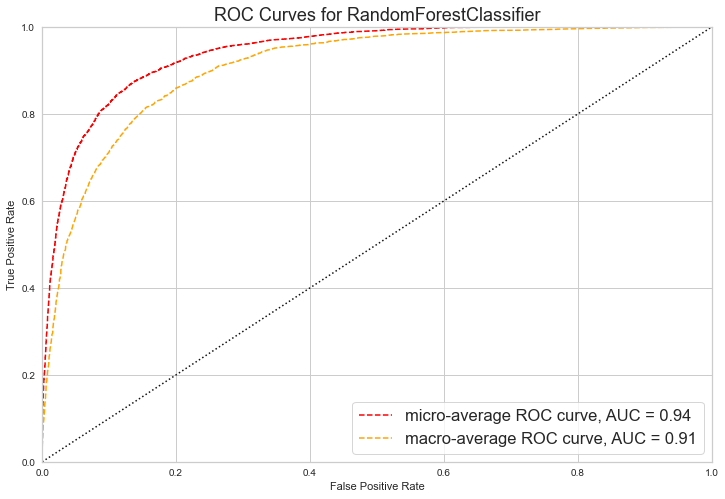

In [7]:
fig, ax = plt.subplots(figsize = (12,8))
lw = 2
colors = ['red', 'orange']
sns.set(font_scale = 1.5, style = 'white')
roc_auc(clf, x_train, y_train, X_test=x_test, y_test=y_test, ax=ax, micro=True, macro=True, per_class=False, binary=False, classes=['LDG 0', 'LDG 1', 'Under 6'], encoder=None, is_fitted=True, force_model=False, show=False)
for i in range(2):
    ax.lines[i].set_color(colors[i])
    leg = ax.get_legend()
    leg.legendHandles[i].set_color(colors[i])
    leg.legendHandles[i].set_color(colors[i])


Average precision score, micro-averaged over all classes: 0.89


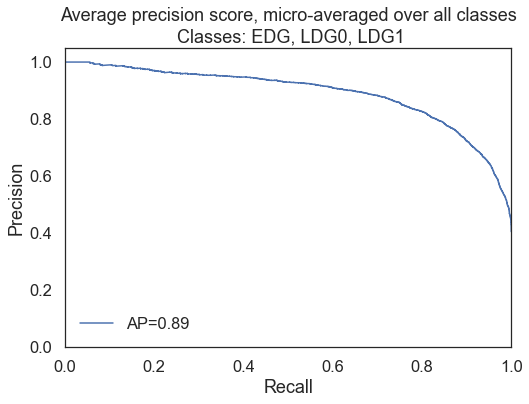

In [8]:
# Use label_binarize to be multi-label like settings
Y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = Y_test.shape[1]

y_score = clf.predict_proba(x_test)

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post',  label ='AP={0:0.2f}'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes\n Classes: EDG, LDG0, LDG1')
plt.legend(loc="lower left")
  

plt.rcParams['figure.figsize'] = 10, 7

In [9]:
y_pred = clf.predict(x_test)
target_names = ['cluster 0', 'cluster 1', 'under 6']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cluster 0       0.59      0.68      0.63       904
   cluster 1       0.50      0.66      0.57       499
     under 6       0.91      0.86      0.88      4505

    accuracy                           0.81      5908
   macro avg       0.67      0.73      0.69      5908
weighted avg       0.83      0.81      0.82      5908



In [10]:
# #shap plots of testset
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(x_test)
# with open('shap_clus_and_out.p', 'wb') as file:
#     pickle.dump([explainer,shap_values], file)

In [11]:
with open('shap_clus_and_out.p', 'rb') as file:
    explainer,shap_values = pickle.load(file)

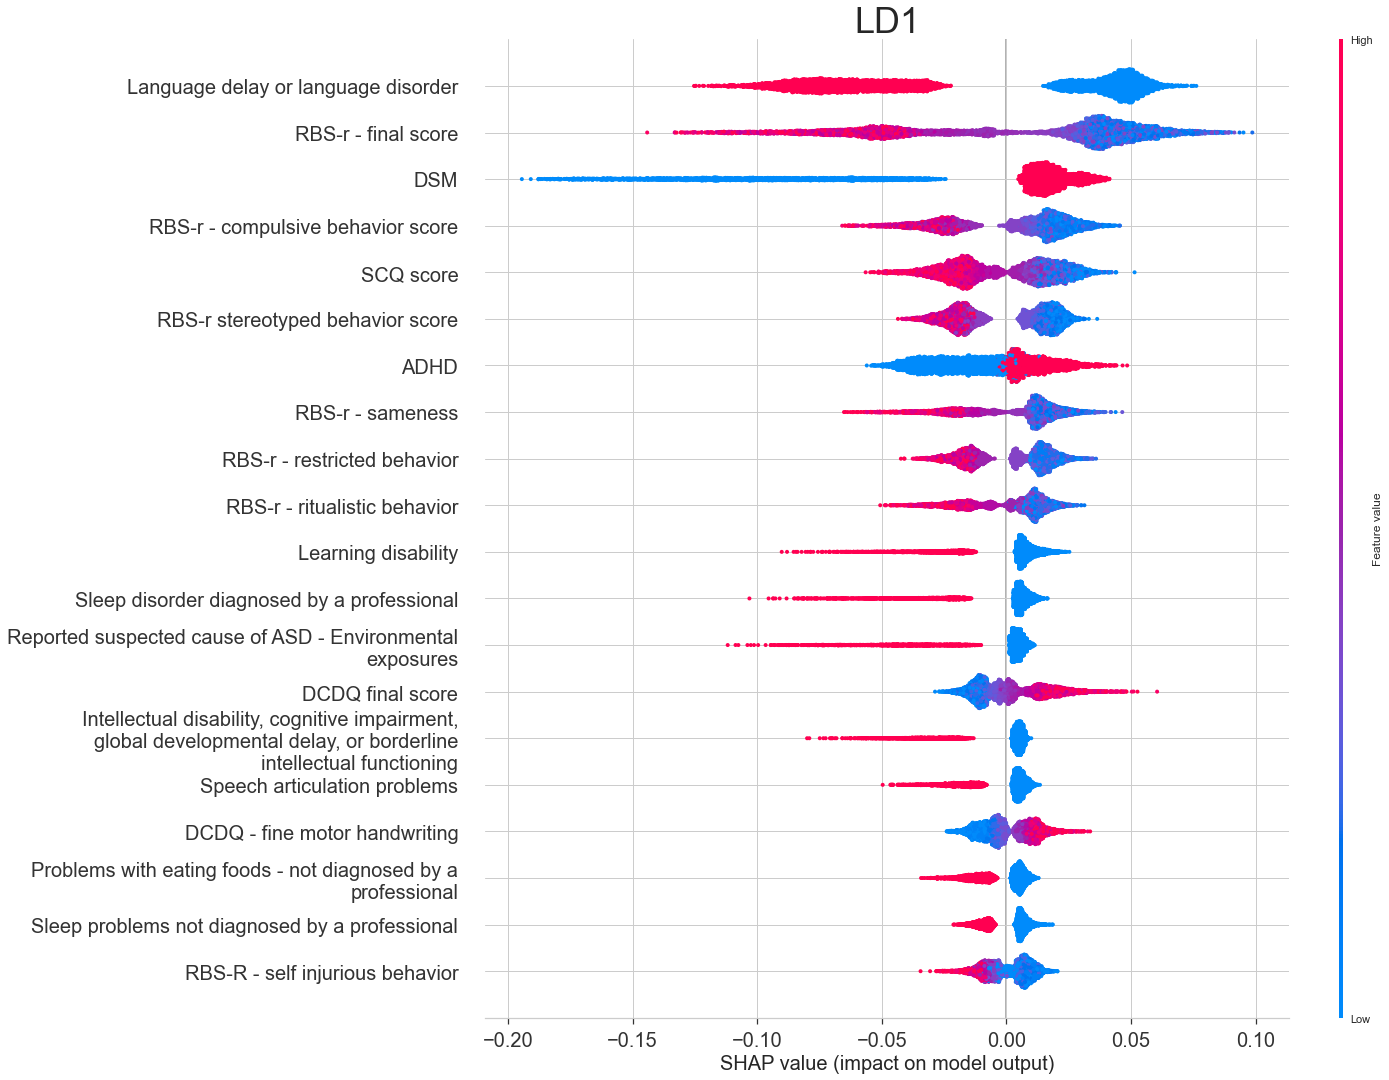

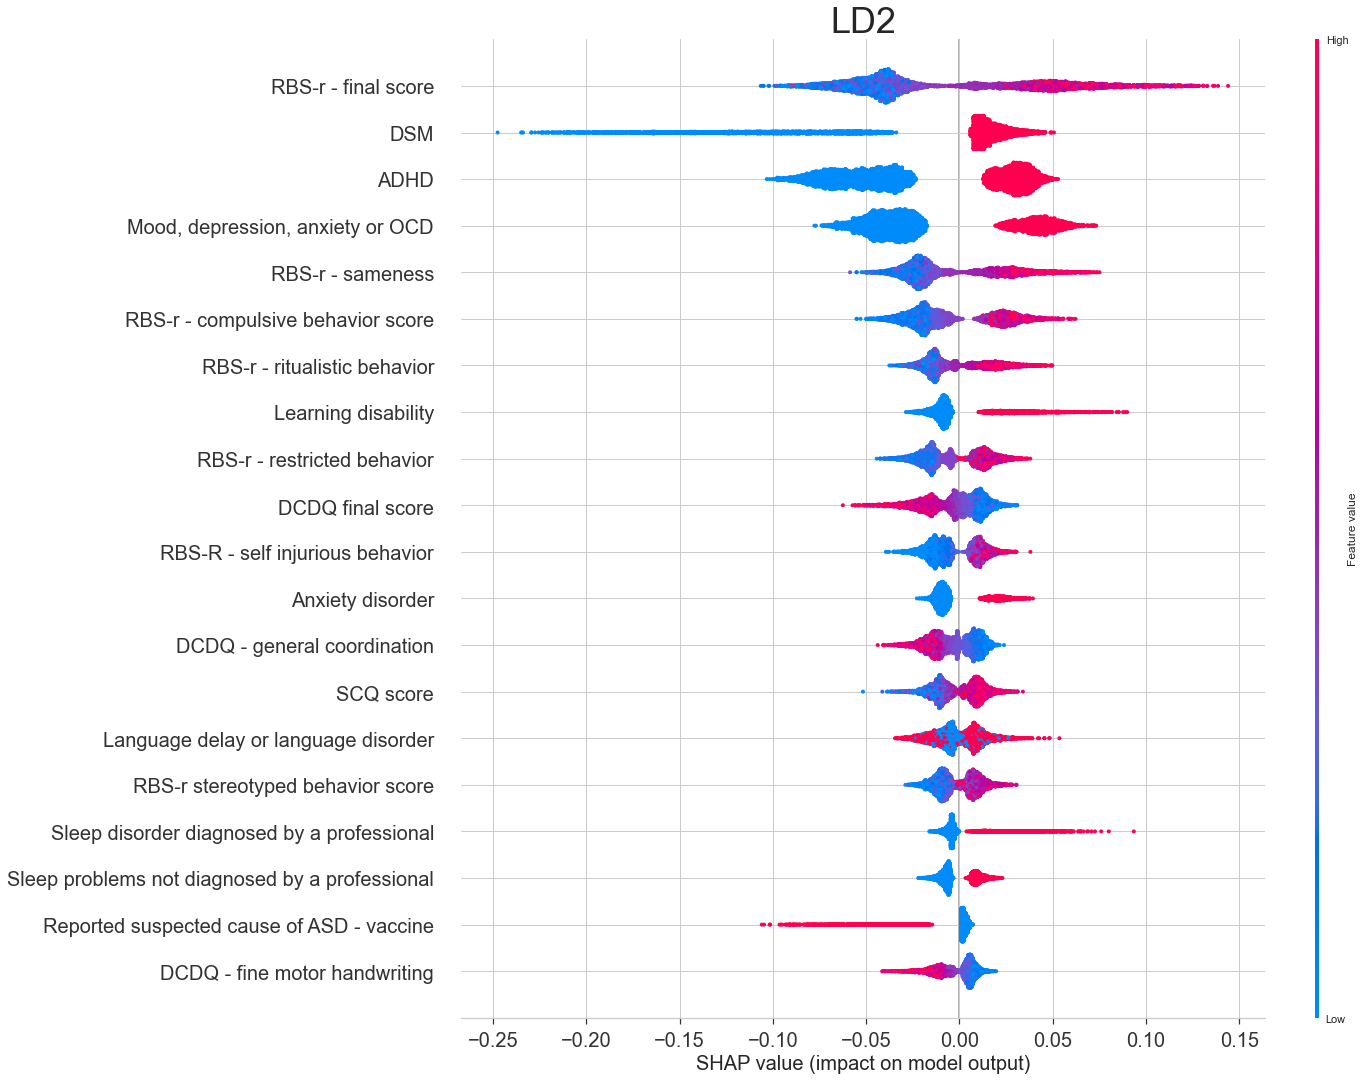

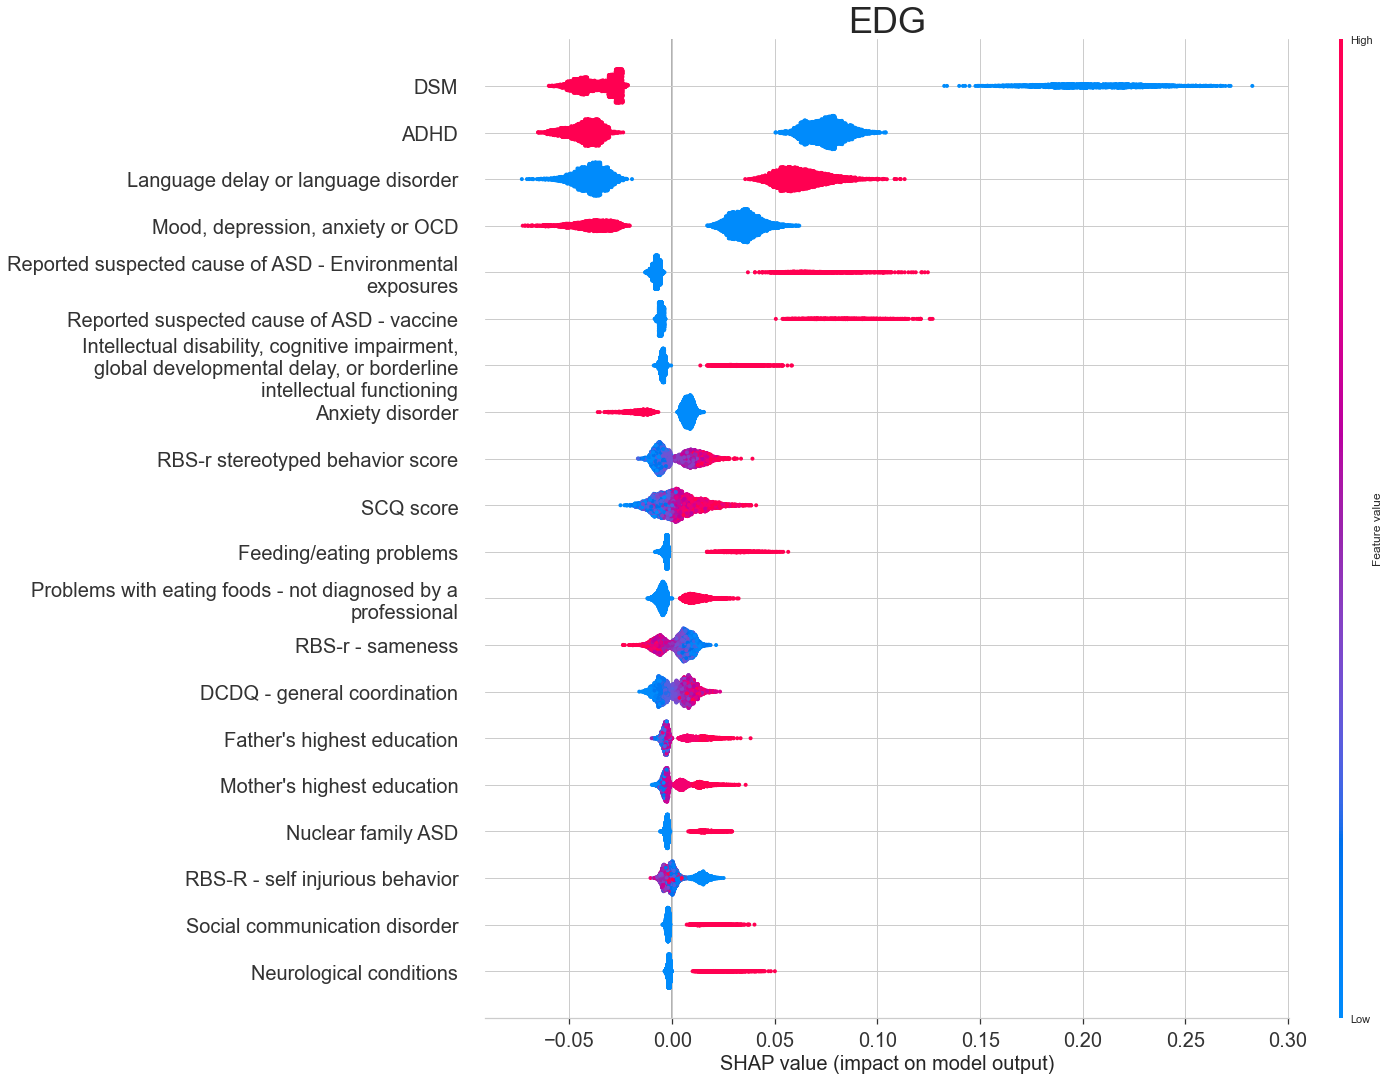

In [12]:
sns.set(style= 'whitegrid')
f = lambda x: textwrap.fill(x.get_text(), 50)

for i in range(3):
    dropped_vars = ['Attention or behavior disorders',
     'Year of birth',
     "Speech/ language/ intellectual/ learning disability/cognitive Impairment/ or other developmental delay or disability"]
    shap_no_att = pd.DataFrame(shap_values[i], columns = x_test.columns).drop(dropped_vars, axis = 1).values
    x_test_no_att = x_test.drop(dropped_vars, axis = 1)
    shap.summary_plot(shap_no_att, x_test_no_att, plot_type = 'dot', max_display = 20, plot_size  = (18,18), show = False)
#     shap.summary_plot(shap_values[i], x_test, plot_type = 'violin', max_display = 20, feature_names = names, plot_size  = (20,18), show = False)
    ax = plt.gca()
    ax.set_title('{}'.format(f'LD{i+1}' if i in [0,1] else 'EDG'), fontsize = 36)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(map(f, ax.get_yticklabels()))
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20)
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20)
    ax.xaxis.label.set_size(20)

        

#     for label in ax.yaxis.get_ticklabels():
#         label.set_bbox(dict(facecolor='none', edgecolor='red'))

    plt.show()